# Predict accuracy


purpose: predict whether a unit's accuracy will be below detection threshold ("dark unit") with fractional logistic regression

We used:
- features that can be used by ephysists as quality metrics:
    - firing rate
    - spike profile (among WaveMap clusters)
    - spike spatial footprint (over sites)
    - background noise (see neuropixels group)
    - layer
    - cell type based on spike temporal duration

- features for understanding, that can not be used by ephysists directly:
    - unit's true distance to nearest site
    - unit's soma size

Do not add:
- inh_mini_frequency (only 1 value)
- morphology (1284 values): not enough repeat for robust modeling

### Setup

activate npx

In [1]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as sinotebooks/1_results/1_accuracy/a_population/2_modeling_accuracy.ipynb
import statsmodels.api as sm
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.formula.api import logit

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, euclidean_distance

EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_10_18"
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["input"]
BLUECONFIG_PATH = data_conf["dataeng"]["blueconfig"]

2024-01-22 18:34:58,276 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-22 18:34:58,292 - root - utils.py - get_config - INFO - Reading experiment config. - done


#### Custom functions

In [3]:
def get_distance_to_site(SortingTrue):
    # calculate each unit's euclidean distance to nearest site
    # - get site coordinates
    Recording = si.load_extractor(RECORDING_PATH)
    Probe = Recording.get_probe()
    sites_coord = Probe.contact_positions

    # - calculate distance
    unit_ids = SortingTrue.unit_ids
    distance_to_site = []
    for unit in unit_ids:
        x = SortingTrue.get_property("x", ids=[unit])
        y = SortingTrue.get_property("y", ids=[unit])
        z = SortingTrue.get_property("z", ids=[unit])
        # store minimum distance between this unit and all sites
        site_dist = []
        for site in sites_coord:
            site_dist.append(euclidean_distance(np.array([x, y, z]).T, site))
        distance_to_site.append(np.min(np.array(site_dist)))
    return distance_to_site

## Get data

In [4]:
# features:
# - firing rate
SortingTrue = si.load_extractor(GT_SORTING_PATH)
SortingTrue.get_property_keys()

['model_type',
 'region',
 'morphology',
 'dynamics_input_resistance',
 'morph_class',
 'model_template',
 'orientation',
 'inh_mini_frequency',
 'orientation_w',
 'dynamics_holding_current',
 'exc_mini_frequency',
 'z',
 'me_combo',
 'sorting_accuracy',
 'firing_rates',
 'layer',
 'synapse_class',
 'orientation_z',
 'dynamics_threshold_current',
 'mtype',
 'orientation_y',
 'y',
 'x',
 'orientation_x',
 'etype',
 'dynamics_resting_potential']

In [5]:
len(np.unique(SortingTrue.get_property("model_template")))

19

In [6]:
# format dataset

# - firing rate
data_df = pd.DataFrame()
data_df["firing_rate"] = np.array(SortingTrue.get_property("firing_rates"))

# - synapse
data_df["synapse_class"] = pd.get_dummies(SortingTrue.get_property("synapse_class"))[
    "EXC"
].values

# - etype
etype_df = pd.get_dummies(SortingTrue.get_property("etype"))
data_df = pd.merge(data_df, etype_df, left_index=True, right_index=True)

# - layer
feature_layer_df = pd.get_dummies(SortingTrue.get_property("layer"))
feature_layer_df.columns = [
    "layer_1",
    "layer_2",
    "layer_3",
    "layer_4",
    "layer_5",
    "layer_6",
]
data_df = pd.merge(data_df, feature_layer_df, left_index=True, right_index=True)

# - distance to nearest site
data_df["distance"] = get_distance_to_site(SortingTrue)

# - exc_mini_frequency (5 unique values)
data_df["exc_mini_frequency"] = SortingTrue.get_property("exc_mini_frequency")

# - dynamics_holding_current
data_df["dynamics_holding_current"] = SortingTrue.get_property(
    "dynamics_holding_current"
)

# - dynamics_holding_current
data_df["model_template"] = SortingTrue.get_property("model_template")

# - predicted: sorting accuracy
data_df["sorting_accuracy"] = SortingTrue.get_property("sorting_accuracy")
data_df.sort_values(by="firing_rate")

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,firing_rate,synapse_class,bAC,bNAC,bSTUT,cACint,cADpyr,cNAC,cSTUT,dNAC,...,layer_2,layer_3,layer_4,layer_5,layer_6,distance,exc_mini_frequency,dynamics_holding_current,model_template,sorting_accuracy
116,0.001701,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,26.942865,0.013875,-0.010166,hoc:cADpyr_L2TPC,0.009434
26,0.001701,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,49.090884,0.013875,-0.013333,hoc:cADpyr_L2TPC,0.001167
63,0.001701,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,33.441549,0.013875,-0.016050,hoc:cADpyr_L2TPC,0.009091
66,0.001701,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,25.720716,0.013875,-0.016423,hoc:cADpyr_L2TPC,0.009524
67,0.001701,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,35.362694,0.013875,-0.010999,hoc:cADpyr_L2TPC,0.007576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,4.670070,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,11.649583,0.010108,-0.024372,hoc:cNAC_L6BTC,0.993452
425,4.675172,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,28.322940,0.010108,-0.033408,hoc:cACint_L23MC,0.812365
544,4.840139,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,14.414273,0.003295,-0.050126,hoc:cADpyr_L6BPC,0.995434
1301,5.125853,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,41.270561,0.010108,-0.080658,hoc:cNAC_L6BTC,0.017304


## Model

Drivers of sorting accuracy:
- firing rate
- distance
- the effect of firing rate on sorting accuracy depends on the layer and on the neuron distance to the nearest site

etype has no effect

In [7]:
import statsmodels.api as sm

# null model
null_model = sm.GLM.from_formula(
    "sorting_accuracy ~ 1", family=sm.families.Binomial(), data=data_df
)
null_model = null_model.fit()
print("null_model ")
print(null_model.summary())


# model 1
model1 = sm.GLM.from_formula(
    "sorting_accuracy ~ 1 + firing_rate", family=sm.families.Binomial(), data=data_df
)
result1 = model1.fit()
print("MODEL 1")
print(result1.summary())


# model 1a
model1a = sm.GLM.from_formula(
    "sorting_accuracy ~ 1 + firing_rate + distance + exc_mini_frequency",
    family=sm.families.Binomial(),
    data=data_df,
)
result1a = model1a.fit()
print("MODEL 1a")
print(result1a.summary())


# model 2
model2 = sm.GLM.from_formula(
    "sorting_accuracy ~ 1 + firing_rate + synapse_class + firing_rate * synapse_class",
    family=sm.families.Binomial(),
    data=data_df,
)
result2 = model2.fit()
print("MODEL 2")
print(result2.summary())


# model 3
# interaction term: does the effect of x1 on y changes for different x2?
model3 = sm.GLM.from_formula(
    """sorting_accuracy ~ 1 
    + firing_rate
    + synapse_class
    + distance
    + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
    + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
    """,
    family=sm.families.Binomial(),
    data=data_df,
)
result3 = model3.fit()
print("MODEL 3")
print(result3.summary())

# model 3
# interaction term: does the effect of x1 on y changes for different x2?
model4 = sm.GLM.from_formula(
    """sorting_accuracy ~ 1 
    + firing_rate
    + distance
    + synapse_class
    + exc_mini_frequency
    + dynamics_holding_current
    + model_template
    + bAC + bNAC + bSTUT + cACint + cADpyr + cNAC + cSTUT + dNAC + dSTUT
    + layer_1 + layer_2 + layer_3 + layer_4 + layer_5 + layer_6 
    + firing_rate : distance
    + firing_rate : synapse_class
    + firing_rate : layer_1 
    + firing_rate : layer_2 
    + firing_rate : layer_3
    + firing_rate : layer_4 
    + firing_rate : layer_5 
    + firing_rate : layer_6 
    + bAC : firing_rate
    + bNAC : firing_rate
    + bSTUT : firing_rate
    + cACint : firing_rate
    + cADpyr : firing_rate
    + cNAC : firing_rate
    + cSTUT : firing_rate
    + dNAC : firing_rate
    + dSTUT : firing_rate                        
    """,
    family=sm.families.Binomial(),
    data=data_df,
)
result4 = model4.fit()
print("MODEL 4")
print(result4.summary())

null_model 
                 Generalized Linear Model Regression Results                  
Dep. Variable:       sorting_accuracy   No. Observations:                 1310
Model:                            GLM   Df Residuals:                     1309
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -617.83
Date:                Fri, 08 Dec 2023   Deviance:                       722.17
Time:                        13:40:54   Pearson chi2:                     696.
No. Iterations:                     3   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1282      0.064    -17.

In [8]:
# difference in BIC ()
result4.bic - null_model.bic

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


-83.36715718634332

### Plot feature weights

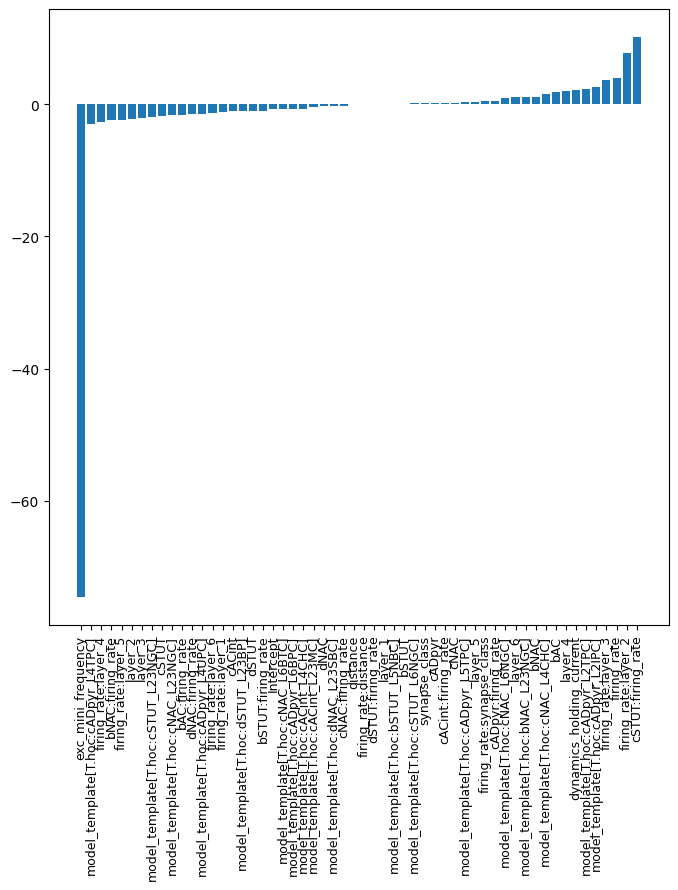

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.bar(
    x=result4.params.sort_values().index, height=result4.params.sort_values().values
)
plt.xticks(rotation=90, fontsize=9)

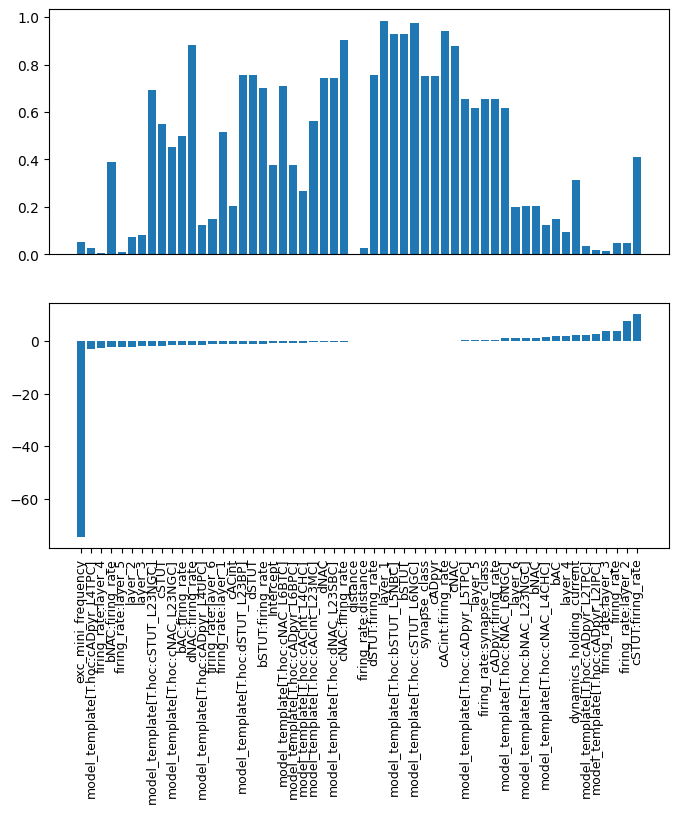

In [62]:
df = pd.DataFrame(data=[result4.params.values, result4.pvalues.values]).T
df.index = result4.params.index
df.columns = ["weights", "pvalues"]

sorted_df = df[["weights", "pvalues"]].sort_values(by="weights")

fig, axes = plt.subplotss(2, 1, figsize=(8, 7))
axes[0].bar(x=sorted_df.index, height=sorted_df["pvalues"].values)
axes[0].set_xticks([])
axes[0].set_xticks([])
# axes[0].hlines(xmin=0,xmax=10, 0.05)

axes[1].bar(x=sorted_df.index, height=sorted_df["weights"].values)
plt.xticks(rotation=90, fontsize=9)

In [33]:
result4.pvalues

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.bar(
    x=result4.params.sort_values().index, height=result4.params.sort_values().values
)
plt.xticks(rotation=90, fontsize=9)

Intercept                             0.375391
model_template[T.hoc:bNAC_L23NGC]     0.203987
model_template[T.hoc:bSTUT_L5NBC]     0.928172
model_template[T.hoc:cACint_L23MC]    0.561382
model_template[T.hoc:cACint_L4CHC]    0.267957
model_template[T.hoc:cADpyr_L2IPC]    0.019217
model_template[T.hoc:cADpyr_L2TPC]    0.034847
model_template[T.hoc:cADpyr_L4TPC]    0.024330
model_template[T.hoc:cADpyr_L4UPC]    0.124271
model_template[T.hoc:cADpyr_L5TPC]    0.656326
model_template[T.hoc:cADpyr_L6BPC]    0.374714
model_template[T.hoc:cNAC_L23NGC]     0.453464
model_template[T.hoc:cNAC_L4CHC]      0.121670
model_template[T.hoc:cNAC_L6BTC]      0.709275
model_template[T.hoc:cNAC_L6NGC]      0.616182
model_template[T.hoc:cSTUT_L23NGC]    0.692816
model_template[T.hoc:cSTUT_L6NGC]     0.976087
model_template[T.hoc:dNAC_L23SBC]     0.744328
model_template[T.hoc:dSTUT_L23BP]     0.755845
firing_rate                           0.047353
distance                              0.000016
synapse_class

In [9]:
# plt.plot(result1.predict(linear=True), result1.resid_pearson, "o")
# new_x = sm.add_constant(data_df[["firing_rate", "synapse_class"]])
# create feature matrix for prediction (including intercept in first column)
x_test = sm.add_constant(data_df[["firing_rate"]])
x_test

,const,firing_rate
0,1.0,0.025510
1,1.0,0.017007
2,1.0,0.061225
3,1.0,0.011905
4,1.0,0.047619
...,...,...
1305,1.0,0.015306
1306,1.0,0.005102
1307,1.0,2.005103
1308,1.0,0.091837


/tmp/ipykernel_226559/1256588943.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df["predictions"] = predicted


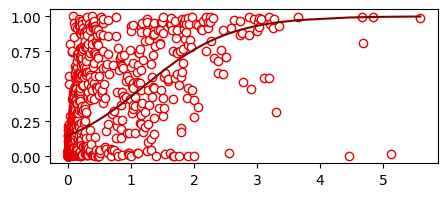

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
MARKERSIZE = 6

# predict
predicted = result1.predict(x_test)

# sort data for plotting
sorted_df = pd.DataFrame()
sorted_df = data_df[["firing_rate", "sorting_accuracy"]]
sorted_df["predictions"] = predicted
sorted_df = sorted_df.sort_values(by="firing_rate")

# plot data
plt.plot(
    sorted_df["firing_rate"],
    sorted_df["sorting_accuracy"],
    "o",
    markerfacecolor="w",
    markeredgecolor=[0.9, 0, 0],
    markersize=MARKERSIZE,
)

# plot prediction
plt.plot(
    sorted_df["firing_rate"], sorted_df["predictions"], zorder=1000, color=[0.5, 0, 0]
)

#### Evaluate model

In [216]:
# report R-squared
result4.pseudo_rsquared()

0.23742526501032035

### References

https://github.com/statsmodels/statsmodels/issues/9048
https://www.statsmodels.org/dev/examples/notebooks/generated/quasibinomial.html